In [ ]:
# 단점 : 긴기간의 의존성을 완벽하게 다룰 수 없음, 단순한 예제에 대해서는 사람이 신중하게 parameter를 골라서 그 문제를 해결할 수 있음
# 단점을 보안해서 나온게 LSTM(Long Short-Term Memory)

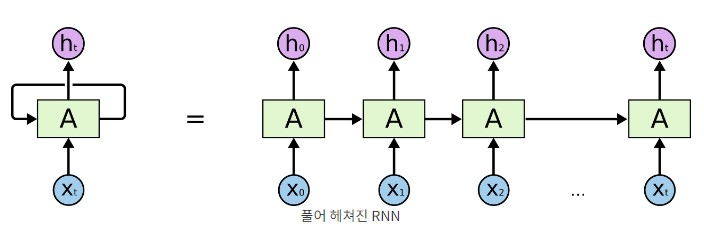

RNN의 구조

단점을 보완해서 나온 LSTM

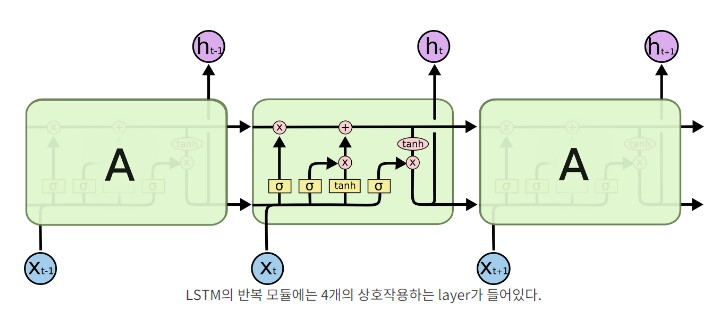

In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas_datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf
from pandas_datareader import data

In [ ]:
# yf.pdr_override()

# start_date = '2020-01-01' # 데이터 수집 시작날짜
# end_date = '2022-09-26'  # 데이터 수집 마지막 날짜

# samsung = data.get_data_yahoo('005930.KS', start_date, end_date)
# samsung


In [ ]:
## 6개의 컬럼 input dimension
## Sequence = 7 7일의 정보를 가지고 마지막 1일의 종가 예측을 하는것
## Output dimension = 1

In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from pandas.core.dtypes.cast import date
#삼성 전자 주가 데이터
#시작 날짜 설정
start = (2000, 1, 1)
start = datetime.datetime(*start)
print(type(start)) #datetime.datetime

#끝나는 날짜 설정
end = datetime.date.today()
df = pdr.DataReader('005930.KS','yahoo',start, end)
df.tail()

<class 'datetime.datetime'>


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-09-21,55500.0,55000.0,55400.0,55300.0,11863700.0,55300.0
2022-09-22,54700.0,54300.0,54600.0,54400.0,12786510.0,54400.0
2022-09-23,54900.0,54200.0,54400.0,54500.0,10555964.0,54500.0
2022-09-26,54200.0,53600.0,53700.0,53900.0,15008449.0,53900.0
2022-09-27,54200.0,53500.0,53800.0,54100.0,10630620.0,54100.0


In [ ]:
seq_length = 7 #몇일의 데이터를 가지고 할꺼냐? 내 맘대로 설정 가능
batch = 50
train_size = int(len(df)*0.7)
train_set = df[0:train_size]
test_set = df[train_size-seq_length:] # 7개씩 묶어서 넘어가기때문에 빼줘야 한다.

In [ ]:
train_set

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-04,6110.0,5660.0,6000.0,6110.0,74195000.0,4623.467773
2000-01-05,6060.0,5520.0,5800.0,5580.0,74680000.0,4222.414062
2000-01-06,5780.0,5580.0,5750.0,5620.0,54390000.0,4252.681152
2000-01-07,5670.0,5360.0,5560.0,5540.0,40305000.0,4192.144531
2000-01-10,5770.0,5580.0,5600.0,5770.0,46880000.0,4366.187500
...,...,...,...,...,...,...
2015-09-24,22700.0,22500.0,22520.0,22520.0,6636050.0,18714.736328
2015-09-25,22500.0,22180.0,22400.0,22240.0,10458000.0,18482.046875
2015-09-30,22680.0,21800.0,22000.0,22680.0,22946800.0,18847.701172


In [ ]:
train_set.iloc[:,:-1] # Adj Close 칼럼 제거

,High,Low,Open,Close,Volume
Date,,,,,
2000-01-04,6110.0,5660.0,6000.0,6110.0,74195000.0
2000-01-05,6060.0,5520.0,5800.0,5580.0,74680000.0
2000-01-06,5780.0,5580.0,5750.0,5620.0,54390000.0
2000-01-07,5670.0,5360.0,5560.0,5540.0,40305000.0
2000-01-10,5770.0,5580.0,5600.0,5770.0,46880000.0
...,...,...,...,...,...
2015-09-24,22700.0,22500.0,22520.0,22520.0,6636050.0
2015-09-25,22500.0,22180.0,22400.0,22240.0,10458000.0
2015-09-30,22680.0,21800.0,22000.0,22680.0,22946800.0


In [ ]:
# Adj Close 칼럼만 확인
train_set.iloc[:,[-1]]

,Adj Close
Date,
2000-01-04,4623.467773
2000-01-05,4222.414062
2000-01-06,4252.681152
2000-01-07,4192.144531
2000-01-10,4366.187500
...,...
2015-09-24,18714.736328
2015-09-25,18482.046875
2015-09-30,18847.701172


In [ ]:
# 훈련
np.array(train_set)[0:7, :]

array([[6.11000000e+03, 5.66000000e+03, 6.00000000e+03, 6.11000000e+03,
        7.41950000e+07, 4.62346777e+03],
       [6.06000000e+03, 5.52000000e+03, 5.80000000e+03, 5.58000000e+03,
        7.46800000e+07, 4.22241406e+03],
       [5.78000000e+03, 5.58000000e+03, 5.75000000e+03, 5.62000000e+03,
        5.43900000e+07, 4.25268115e+03],
       [5.67000000e+03, 5.36000000e+03, 5.56000000e+03, 5.54000000e+03,
        4.03050000e+07, 4.19214453e+03],
       [5.77000000e+03, 5.58000000e+03, 5.60000000e+03, 5.77000000e+03,
        4.68800000e+07, 4.36618750e+03],
       [6.10000000e+03, 5.77000000e+03, 5.82000000e+03, 5.77000000e+03,
        5.97450000e+07, 4.36618750e+03],
       [5.74000000e+03, 5.60000000e+03, 5.61000000e+03, 5.72000000e+03,
        2.92200000e+07, 4.32835400e+03]])

In [ ]:
# 예측
np.array(train_set)[7, [-1]]

array([4320.78417969])

In [ ]:
scaler_x = MinMaxScaler()
scaler_x.fit(train_set.iloc[:,:-1])

train_set.iloc[:,:-1] = scaler_x.transform(train_set.iloc[:,:-1])
test_set.iloc[:,:-1] = scaler_x.transform(test_set.iloc[:,:-1])

#output scale
scaler_y = MinMaxScaler()
scaler_y.fit(train_set.iloc[:,[-1]])

train_set.iloc[:,-1] = scaler_y.transform(train_set.iloc[:,[-1]])
test_set.iloc[:,-1] = scaler_y.transform(test_set.iloc[:,[-1]])



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [ ]:
train_set

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-04,0.115837,0.113525,0.118900,0.117402,4.518162e-01,0.109034
2000-01-05,0.114108,0.108619,0.112027,0.098993,4.547697e-01,0.091937
2000-01-06,0.104426,0.110722,0.110309,0.100382,3.312121e-01,0.093227
2000-01-07,0.100622,0.103013,0.103780,0.097603,2.454404e-01,0.090646
2000-01-10,0.104080,0.110722,0.105155,0.105592,2.854794e-01,0.098066
...,...,...,...,...,...,...
2015-09-24,-0.095412,-0.084769,-0.087262,-0.094801,2.460844e-10,-0.088035
2015-09-25,-0.095412,-0.084769,-0.087262,-0.094801,3.878136e-10,-0.088036
2015-09-30,-0.095412,-0.084769,-0.087262,-0.094801,8.509352e-10,-0.088035


In [ ]:
test_set

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-09-22,-0.095411,-0.084768,-0.087261,-0.094800,4.647885e-10,-0.088035
2015-09-23,-0.095412,-0.084769,-0.087261,-0.094801,3.664705e-10,-0.088035
2015-09-24,-0.095412,-0.084769,-0.087262,-0.094801,2.460844e-10,-0.088035
2015-09-25,-0.095412,-0.084769,-0.087262,-0.094801,3.878136e-10,-0.088036
2015-09-30,-0.095412,-0.084769,-0.087262,-0.094801,8.509352e-10,-0.088035
...,...,...,...,...,...,...
2022-09-21,1.823651,1.842327,1.816495,1.825981,7.224492e-02,2.269380
2022-09-22,1.795989,1.817800,1.789003,1.794720,7.786445e-02,2.231013
2022-09-23,1.802905,1.814296,1.782131,1.798194,6.428136e-02,2.235276


In [ ]:
def build_dataset(time_series, seq_length):
    dataX=[]
    dataY=[]

    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

train_X, train_Y = build_dataset(np.array(train_set), seq_length)
test_X, test_Y = build_dataset(np.array(test_set), seq_length)

print(train_X.shape)
print(train_Y.shape)


(3987, 7, 6)
(3987, 1)


In [ ]:
# to Tensor

train_X_tensor = torch.FloatTensor(train_X)
train_Y_tensor = torch.FloatTensor(train_Y)

test_X_tensor = torch.FloatTensor(test_X)
test_Y_tensor = torch.FloatTensor(test_Y)



In [ ]:
dataset = TensorDataset(train_X_tensor, train_Y_tensor)

dataloader = DataLoader(dataset, batch_size = batch, shuffle = True, drop_last = True)

In [ ]:
# setting parameter 
data_dim = 6
hidden_dim = 30
output_dim = 1
learning_rate = 0.001
epochs = 100

# Model set
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()       
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        #self.input_dim = input_dim

        # torch에서 LSTM기능을 제공 하기 때문에 간단하게 구현 가능
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers = layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True)
    
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.layers, self.seq_len, self.hidden_dim),
            torch.zeros(self.layers, self.seq_len, self.hidden_dim)
        )
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:,-1])
        return x


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
#device = torch.device('cpu')

def train_model(model , train_df, num_epochs = None, lr = None , verbose = 10, patience = 10):

    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs

    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)

        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples

            model.reset_hidden_state()

            outputs = model(x_train)

            loss = criterion(outputs, y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_cost += loss/total_batch

        train_hist[epoch] = avg_cost
        
        if epoch % verbose == 0:
            print('Epoch : ','%04d' % (epoch), 'train loss :','{:.4f}'.format(avg_cost))

        if (epoch % patience ==0) & (epoch != 0):

            if train_hist[epoch-patience] < train_hist[epoch]:
                print('stop!!')
                break

    return model.eval(), train_hist



In [ ]:
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model, train_hist = train_model(net, dataloader, num_epochs = epochs, lr = learning_rate, verbose = 20, patience=10)

RuntimeError: ignored

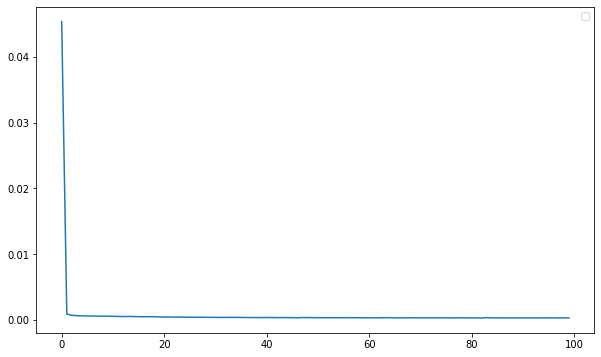

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(train_hist)
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    pred = []
    for pr in range(len(test_X_tensor)):
        
        model.reset_hidden_state()

        predict = model(torch.unsqueeze(test_X_tensor[pr],0))
        predict = torch.flatten(predict).item()
        pred.append(predict)
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1,1))
    test_Y_inverse = scaler_y.inverse_transform(test_Y_tensor)

    

In [ ]:
pred_inverse

array([[  149.87195628],
       [15574.50770548],
       [17890.00385566],
       ...,
       [42333.2092033 ],
       [42424.32868875],
       [42021.97401132]])

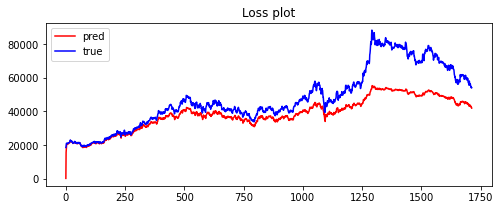

In [ ]:
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, color='r', label ='pred')
plt.plot(np.arange(len(test_Y_inverse)), test_Y_inverse, color='b', label ='true')
plt.title('Loss plot')
plt.legend()
plt.show()